# MBAN 6400 Group Project(Part A)

In [22]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy.cluster.vq import whiten,vq,kmeans
import seaborn as sns

In [46]:
# read data
cc_data = pd.read_csv('credit_card.csv')
cc_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.90,0.82,95.40,0.00,95.4,0.00,0.17,0.00,0.08,0.00,0.0,2.0,1000.0,201.80,139.51,0.00,12.0
1,C10002,3202.47,0.91,0.00,0.00,0.0,6442.95,0.00,0.00,0.00,0.25,4.0,0.0,7000.0,4103.03,1072.34,0.22,12.0
2,C10003,2495.15,1.00,773.17,773.17,0.0,0.00,1.00,1.00,0.00,0.00,0.0,12.0,7500.0,622.07,627.28,0.00,12.0
3,C10004,1666.67,0.64,1499.00,1499.00,0.0,205.79,0.08,0.08,0.00,0.08,1.0,1.0,7500.0,0.00,NaN,0.00,12.0
4,C10005,817.71,1.00,16.00,16.00,0.0,0.00,0.08,0.08,0.00,0.00,0.0,1.0,1200.0,678.33,244.79,0.00,12.0


In [47]:
cc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

In [48]:
data = cc_data.copy()
data['ONEOFFPURCHASES_total']=data['PURCHASES']-data['INSTALLMENTS_PURCHASES']


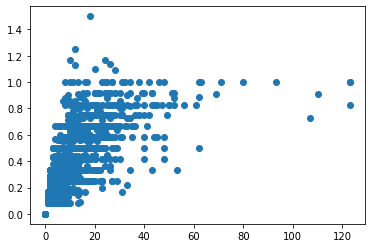

In [49]:
plt.scatter(data.CASH_ADVANCE_TRX,data.CASH_ADVANCE_FREQUENCY)

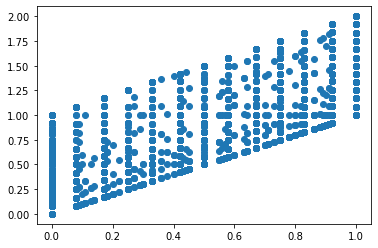

In [50]:
plt.scatter(data.PURCHASES_INSTALLMENTS_FREQUENCY,data.ONEOFF_PURCHASES_FREQUENCY+data.PURCHASES_INSTALLMENTS_FREQUENCY)

In [51]:
# nulll value check
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
ONEOFFPURCHASES_total                 0
dtype: int64

In [52]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   float64
 12  PURCHA

## Missing Value imputation

In [53]:
# payments = 0 and MINIMUM_PAYMENTS = NaN, assign MINIMUM_PAYMENTS to 0, else assign to nan
# drop the row where CREDIT_LIMIT is missing
values = data[(data['PAYMENTS']==0)]['MINIMUM_PAYMENTS'].isna().map({False: np.nan, True: 0})
data['MINIMUM_PAYMENTS'] = data['MINIMUM_PAYMENTS'].fillna(values)
data = data.dropna(subset=['CREDIT_LIMIT'])

In [54]:
# assign all other null value in MINIMUM_PAYMENTS as average value in the column
data['MINIMUM_PAYMENTS'].fillna(data['MINIMUM_PAYMENTS'].median(),inplace=True)

In [55]:
X = data.drop(columns = ['CUST_ID'])

In [56]:
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

In [57]:
for column in X.columns:
    data = X[column]
    percent = str(round(outlier_percent(data), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.67%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 8.98%
Outliers in "PURCHASES_TRX": 8.56%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 10.07%
Outliers in "PRC_FULL_PAYMENT": 16.47%
Outliers in "TENURE": 15.25%
Outliers in "ONEOFFPURCHASES_total": 11.35%


In [58]:
X.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,ONEOFFPURCHASES_total
count,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000
mean,1564.647591,0.877527,1003.316936,592.503572,411.113579,978.959606,0.490316,0.202248,0.364611,0.134966,3.249078,14.711476,4494.449450,1733.336537,836.478091,0.153619,11.517935,592.203357
std,2081.583987,0.237019,2136.727848,1659.968851,904.378205,2097.264337,0.401637,0.298557,0.397631,0.200289,6.824987,24.858552,3638.815726,2895.168177,2335.396498,0.292671,1.337134,1660.077911
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,6.000000,-600.000000
25%,128.370000,0.890000,39.800000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.280000,164.690000,0.000000,12.000000,0.000000
50%,873.680000,1.000000,361.490000,38.000000,89.000000,0.000000,0.500000,0.080000,0.170000,0.000000,0.000000,7.000000,3000.000000,857.060000,294.585000,0.000000,12.000000,38.000000
75%,2054.370000,1.000000,1110.170000,577.830000,468.650000,1113.870000,0.920000,0.300000,0.750000,0.220000,4.000000,17.000000,6500.000000,1901.280000,788.720000,0.140000,12.000000,576.000000
max,19043.140000,1.000000,49039.570000,40761.250000,22500.000000,47137.210000,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.480000,76406.210000,1.000000,12.000000,40761.250000


In [59]:
# rescale each feature dimension of the observation set by its standard deviation
scaled_X = pd.DataFrame(whiten(X), columns = X.columns)
pt = PowerTransformer()
transformed_data = pd.DataFrame(pt.fit_transform(scaled_X), columns = X.columns)

In [60]:
transformed_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,ONEOFFPURCHASES_total
count,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03,8.949000e+03
mean,6.987123e-17,-5.970814e-16,2.223175e-16,-6.987123e-17,1.095708e-16,2.381974e-17,1.984978e-17,-1.842060e-16,-2.064377e-17,5.954934e-17,4.446351e-17,1.302146e-16,-3.811158e-16,8.257509e-17,1.651502e-16,-1.715021e-16,7.622316e-17,1.270386e-16
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00
min,-1.289758e+00,-2.069730e+00,-1.137952e+00,-8.278035e-01,-9.295894e-01,-8.048223e-01,-1.311984e+00,-9.277662e-01,-1.021050e+00,-9.034555e-01,-8.589017e-01,-1.204238e+00,-2.381542e+00,-1.670866e+00,-1.547519e+00,-6.907014e-01,-2.525538e+00,-7.962058e+00
25%,-1.025225e+00,-4.910255e-01,-1.005020e+00,-8.278035e-01,-9.295894e-01,-8.048223e-01,-1.018097e+00,-9.277662e-01,-1.021050e+00,-9.034555e-01,-8.589017e-01,-9.862116e-01,-9.400932e-01,-8.286119e-01,-7.699236e-01,-6.907014e-01,4.221480e-01,-8.174961e-01
50%,9.196376e-03,6.193773e-01,-1.726304e-01,-6.233160e-01,-3.437986e-01,-8.048223e-01,1.686180e-01,-1.506798e-02,-1.842911e-01,-9.034555e-01,-8.589017e-01,-4.600143e-02,-1.745980e-01,-1.214885e-01,-3.015891e-01,-6.907014e-01,4.221480e-01,-6.178700e-01
75%,8.150329e-01,6.193773e-01,8.358044e-01,9.340043e-01,9.051805e-01,1.018259e+00,1.045145e+00,1.005341e+00,1.066519e+00,1.035775e+00,1.008208e+00,7.761047e-01,8.761312e-01,7.660691e-01,7.885957e-01,9.796839e-01,4.221480e-01,9.169831e-01
max,2.140364e+00,6.193773e-01,2.046087e+00,1.936805e+00,1.958815e+00,1.864344e+00,1.191579e+00,1.669066e+00,1.339984e+00,1.881126e+00,1.899249e+00,2.146748e+00,2.471178e+00,2.166472e+00,2.095241e+00,1.795082e+00,4.221480e-01,1.950673e+00


In [61]:
for column in transformed_data.columns:
    data = transformed_data[column]
    percent = str(round(outlier_percent(data), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 0.0%
Outliers in "BALANCE_FREQUENCY": 0.0%
Outliers in "PURCHASES": 0.0%
Outliers in "ONEOFF_PURCHASES": 0.0%
Outliers in "INSTALLMENTS_PURCHASES": 0.0%
Outliers in "CASH_ADVANCE": 0.0%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 0.0%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_TRX": 0.0%
Outliers in "PURCHASES_TRX": 0.0%
Outliers in "CREDIT_LIMIT": 0.0%
Outliers in "PAYMENTS": 0.0%
Outliers in "MINIMUM_PAYMENTS": 0.0%
Outliers in "PRC_FULL_PAYMENT": 0.0%
Outliers in "TENURE": 15.25%
Outliers in "ONEOFFPURCHASES_total": 0.02%


(array([1000.,    0.,  365.,    0.,    0.,    0.,    0.,    0.,    0.,
        7584.]),
 array([-2.52553752, -2.23076898, -1.93600043, -1.64123188, -1.34646333,
        -1.05169479, -0.75692624, -0.46215769, -0.16738914,  0.1273794 ,
         0.42214795]),
 <BarContainer object of 10 artists>)

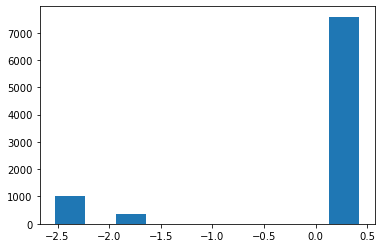

In [39]:
plt.hist(transformed_data.TENURE)

In [63]:
transformed_data= transformed_data.drop(columns='TENURE')

In [65]:
transformed_data.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'ONEOFFPURCHASES_total'],
      dtype='object')

## Clustering

### K-means Clustering

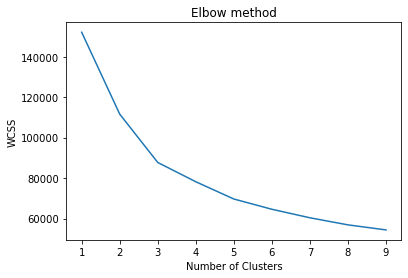

In [66]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(transformed_data) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [67]:
centroids,_ = kmeans(transformed_data, 4)
transformed_data['cluster_labels'], _ = vq(transformed_data, centroids)

In [68]:
cross_tab = pd.crosstab(transformed_data['cluster_labels'],transformed_data['cluster_labels'])
print(cross_tab)

cluster_labels     0     1     2     3
cluster_labels                        
0               2657     0     0     0
1                  0  1738     0     0
2                  0     0  2112     0
3                  0     0     0  2442


In [69]:
centroids,_ = kmeans(transformed_data, 3)
transformed_data['cluster_labels'], _ = vq(transformed_data, centroids)
cross_tab = pd.crosstab(transformed_data['cluster_labels'],transformed_data['cluster_labels'])
print(cross_tab)

cluster_labels     0     1     2
cluster_labels                  
0               2526     0     0
1                  0  3415     0
2                  0     0  3008


In [70]:
centroids,_ = kmeans(transformed_data, 5)
transformed_data['cluster_labels'], _ = vq(transformed_data, centroids)
cross_tab = pd.crosstab(transformed_data['cluster_labels'],transformed_data['cluster_labels'])
print(cross_tab)

cluster_labels     0     1     2     3     4
cluster_labels                              
0               1557     0     0     0     0
1                  0  2549     0     0     0
2                  0     0  2014     0     0
3                  0     0     0  1082     0
4                  0     0     0     0  1747
